# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.set_paths as sps
import src.RT_parameters as rtp
import src.features.RT_EOF_functions as rt_eof
import src.features.RT_visualise as rtv

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_out_version = 'v0'
script_name = f"1.0_Rockall_Trough_transports_{date_str_start[:-2]}_{date_str_end[:-2]}_{fn_out_version}"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = (sps.local_data_dir/f"{script_name}")
Path(data_out_path).mkdir(parents=True, exist_ok=True)

fn_base = "Rockall_Trough_transport_time_series"
file_name_out = f"{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc"

In [5]:
# intput data
fn_in_version = 'v1'
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"

RT_mooring_fn = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_in_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_in_version}.nc"

## Load Data and prepare for calculations

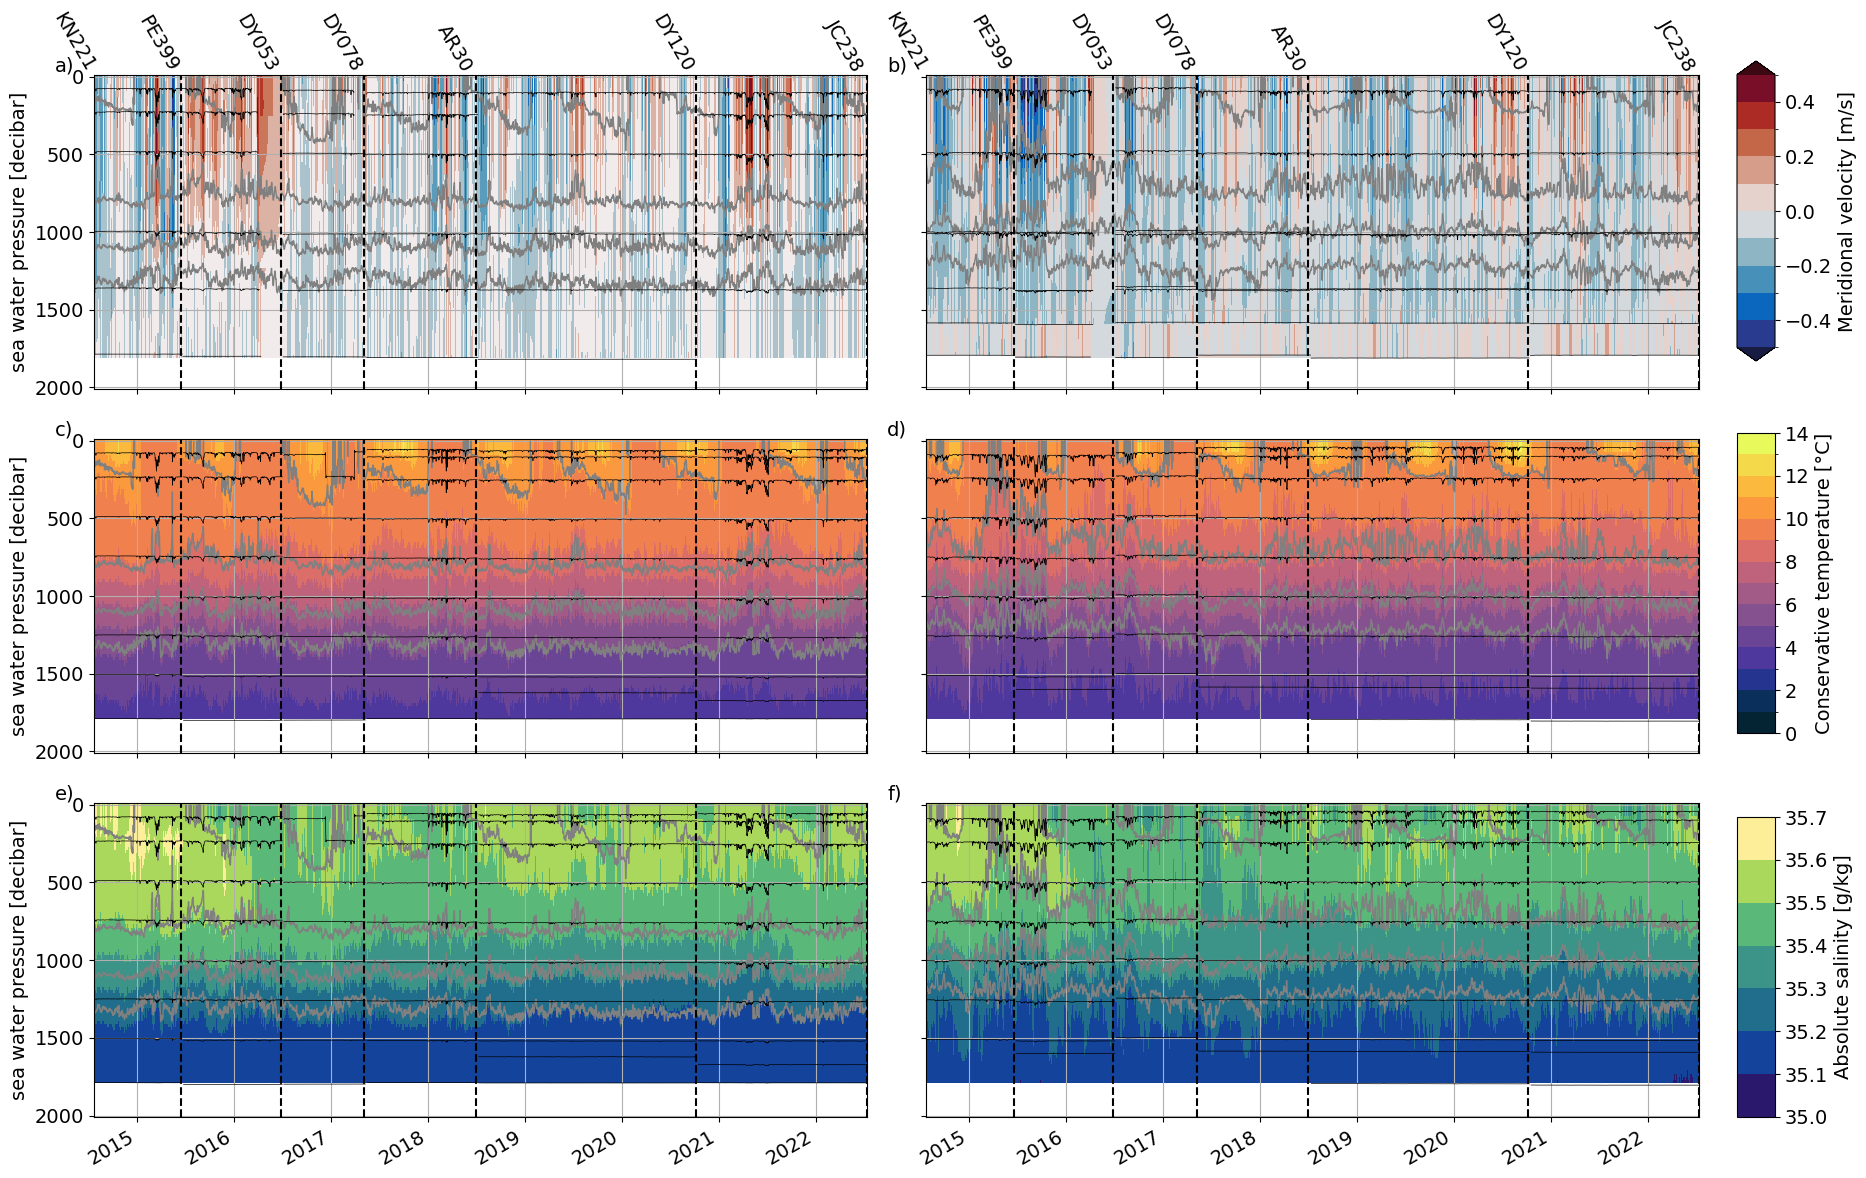

In [6]:
# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

#remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)

# extrapolate upper values of velocity
dim_x = 'TIME'
dim_y = 'PRES'
graphics = False
ds_RT = rtf.extr_moored_RT_timeseries(ds_RT,dim_x,dim_y,graphics=graphics)

#linearly interpolate over time gaps in velocity fields
ds_RT = ds_RT.interpolate_na(dim='TIME')

# Get z from P
ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([ds_RT_loc.lat_RTWB, ds_RT_loc.lat_RTEB]))
ds_RT.depth.attrs = {'name' :'depth',
                     'units' :'m',}
# Create merged WB1/2 CM
ds_RT = rtf.merge_RT_WB1_2(ds_RT)

fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)
# fig.savefig(fig_out_path/f'RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')

ds_RT = rtf.ds_rt_swap_vert_dim(ds_RT)

In [7]:
# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS = rtd.load_glorys()

# load ERA5
ds_ERA5 = xr.open_dataset((sps.ERA5_data_path/sps.ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

# Calculations

## Horizontal and vertical grid parameters

In [23]:
RT_hor_grid = rtf.create_horizontal_grid('v0')

In [25]:
# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
dz = rtf.get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

In [26]:
# Get section bathymetry
bathy_WW = ds_GEBCO.elevation.interp(
            lon=RT_hor_grid.lon_WW, lat=RT_hor_grid.lat_WW
            ).drop(['lon','lat'])
bathy_WW.coords['lon_WW']=RT_hor_grid.lon_WW
bathy_EW = ds_GEBCO.elevation.interp(
            lon=RT_hor_grid.lon_EW, lat=RT_hor_grid.lat_EW
            ).drop(['lon','lat'])
bathy_EW.coords['lon_EW']=RT_hor_grid.lon_EW

## Midbasin transport based on no motion at 1760 dbar

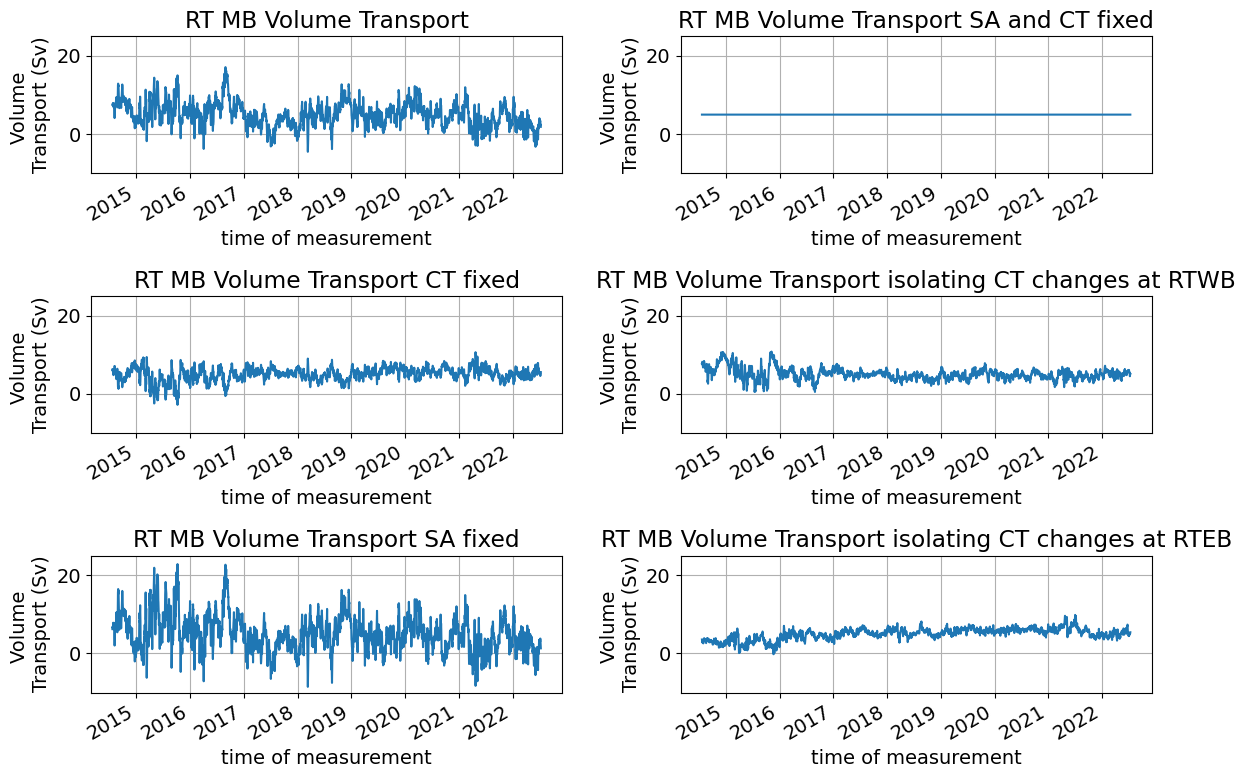

In [27]:
RT_Q_MB, q_MB = rtf.calc_MB_transport(ds_RT,ds_RT_loc,sens_analysis=True,check_plots=True)

In [31]:
# # create MB matrix, fine horizontal grid, new and not in Fraser et al. (2022)
ds_RT_MB_grid = rtf.calc_MB_3D_sections(ds_RT,ds_RT_loc,RT_hor_grid)

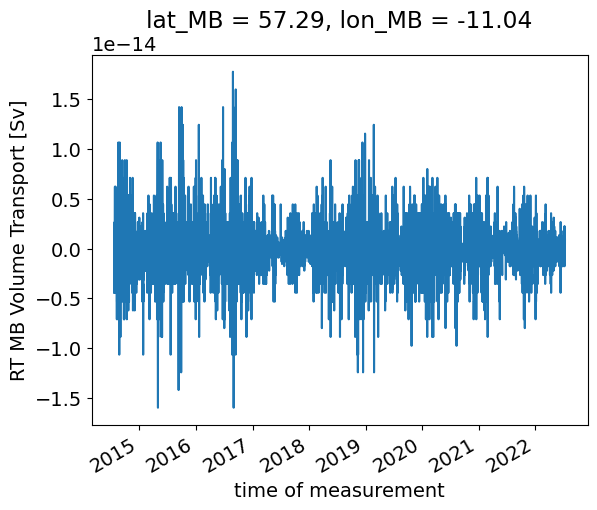

In [32]:
(RT_Q_MB.RT_Q_MB-(ds_RT_MB_grid.q.sum(['depth','lon_MB'],min_count=1)/1e6)).plot()

## Western wedge transport

In [33]:
Q_WW, q_WW = rtf.calc_WW_transport(ds_RT,ds_RT_loc,RT_hor_grid,bathy_WW)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OI\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\sa07kb\AppData\Local\Temp\ipykernel_17052\3186021302.py", line 1, in <module>
    Q_WW, q_WW = rtf.calc_WW_transport(ds_RT,ds_RT_loc,RT_hor_grid,bathy_WW)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sa07kb\Projects\Rockall_Trough_Transports\notebooks\..\src\features\RT_functions.py", line 893, in calc_WW_transport
    q_WW = dx_WW*ds_RT.dz*(v_WW/1e2)
           ^^^^^
NameError: name 'dx_WW' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OI\Lib\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured

In [17]:
# Constant value east of WB1
v_WW = ds_RT.v_RTWB.rename('v_WW').compute()
(v_WW,_) = xr.broadcast(v_WW,xr.DataArray(lon_WW, dims="lon_WW"))
v_WW.coords['lon_WW']=lon_WW
v_WW.coords['lat_WW']=lat_WW
v_WW = v_WW.where(lon_WW>=ds_RT_loc.lon_RTWB1)

# Upper 250 m: Linear decay from WB1 value to 0, western limit is cut off lon
i_bathy = (lon_WW<ds_RT_loc.lon_RTWB1) & (lon_WW>=rtp.lon_cutoff_WW)
y = xr.apply_ufunc(
    np.linspace,
    0,ds_RT.v_RTWB.where((ds_RT.depth<rtp.z_cutoff_WW)),sum(i_bathy),
    input_core_dims=[[],['depth','TIME'],[]],
    output_core_dims=[['lon_WW','depth','TIME']],
    dask='parallelized')

y.coords['lon_WW']= lon_WW[(lon_WW<ds_RT_loc.lon_RTWB1) & (lon_WW>=rtp.lon_cutoff_WW)]

(v_WW,y)=xr.broadcast(v_WW,y)
mask = (v_WW.notnull()+y.notnull())
v_WW = (v_WW.fillna(0)+y.fillna(0)).where(mask)

# Below 250 m: Linear decay from WB1 value to 0, western limit is bathymetry
i_bathy =(-1*bathy_WW.where(
    lon_WW<ds_RT_loc.lon_RTWB1)>ds_RT.depth.where(ds_RT.depth>rtp.z_cutoff_WW))

for idx,bathy in enumerate(i_bathy.sum('lon_WW')):
    if bathy>0:
        y1 = xr.apply_ufunc(
        np.linspace,
        0,ds_RT.v_RTWB.isel(depth=[idx]),bathy,
        input_core_dims=[[],['TIME','depth'],[]],
        output_core_dims=[['lon_WW','TIME','depth']], 
        dask='parallelized')
        
        y1.coords['lon_WW']= lon_WW.values[i_bathy[:,idx]]
        (_,y1)=xr.broadcast(v_WW,y1)
        mask = (v_WW.notnull()+y1.notnull())
        v_WW = (v_WW.fillna(0)+y1.fillna(0)).where(mask)
v_WW = v_WW.fillna(0).where(v_WW.depth<-1*bathy_WW)

# Transport in each cell
q_WW = dx_WW*ds_RT.dz*(v_WW/1e2)

# Integrate for transport timeseries (Sv)
Q_WW = q_WW.sum(['depth','lon_WW'],min_count=1)/1e6 
Q_WW.coords['mask_WW'] = ds_RT.v_RTWB.isel(depth=50).notnull()
Q_WW.attrs['name']= 'RT_Q_WW'
Q_WW.attrs['long_name']= 'RT WW Volume Transport'
Q_WW.attrs['units']='Sv'
Q_WW.attrs['description']='Volume transport at western wedge of Rockall Trough'\
' derived from moored velocity measurements at RTWB1+2'

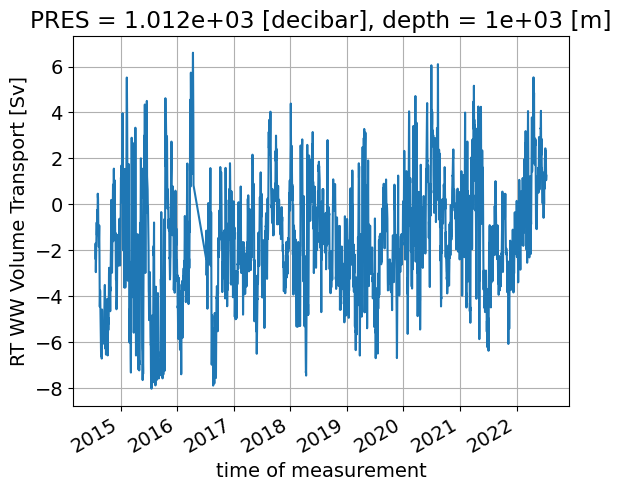

In [18]:
Q_WW.where(Q_WW.mask_WW).plot()
plt.grid()

## Eastern wedge

In [19]:
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=ds_RT_loc.lon_RTADCP,
                    latitude=ds_RT_loc.lat_RTADCP,
                    time=('TIME',ds_RT.TIME.data),
                    depth=('depth',ds_RT.depth.data)) + rtp.corr_model

# Duplicate top and bottom GLORYS-ADCP values
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")

# create velocity matrix with mooring velocity at western border
(v_EW,_) = xr.broadcast(ds_RT.V_EAST/100,xr.DataArray(lon_EW, dims="lon_EW"))
v_EW.coords['lon_EW'] = lon_EW
v_EW0 = v_EW.where((ds_RT.depth<rtp.z_cutoff_EW)).where(lon_EW==lon_EW[-1])*0
v_EW1 = v_EW.where((ds_RT.depth>rtp.z_cutoff_EW))
v_EW = v_EW.where((ds_RT.depth<rtp.z_cutoff_EW)).where(lon_EW<lon_EW[1])

# combine both
mask = (v_EW.notnull()+v_EW1.notnull()+v_EW0.notnull())
v_EW = (v_EW.fillna(0)+v_EW1.fillna(0)+v_EW0.fillna(0)).where(mask)


# create velocity matrix with GLORYS-ADCP closest to the position of RTADCP
(v_EW2,_) = xr.broadcast(v_GLO_RTADCP,xr.DataArray(lon_EW, dims="lon_EW"))
v_EW2.coords['lon_EW'] = lon_EW
v_EW2.coords['lat_EW'] = lat_EW
v_EW3 = v_EW2
v_EW2 = v_EW2.where((ds_RT.depth<rtp.z_cutoff_EW)
                   ).where(lon_EW==v_EW2.lon_EW.sel(lon_EW=ds_RT_loc.lon_RTADCP,method='nearest').values)

# ############################ to be commented if matlab-style (not correct) is wanted - see below
# # Python version (correct version)
mask = (v_EW.notnull()+v_EW2.notnull())
v_EW = (v_EW.fillna(0)+v_EW2.fillna(0)).where(mask)

# ########################### matlab style - to be uncommented if original ouput is wanted (Fraser et al., 2022)
# # In the matlab script the GLORY ADCP data was duplicated to the lon east of the ADCP before interpolating to zero. This causes a deviation of ~0.01cm/s
# # To include the original matlab-style interpolation the following code need to replace the two lines above
# ###########################
# # v_EW3 = v_EW3.where((ds_RT.depth>rtp.z_cutoff_EW)
# #                    ).where(lon_EW==v_EW2.lon_EW.sel(lon_EW=-9.331,method='nearest').values)

# # # combine both
# # mask = (v_EW.notnull()+v_EW2.notnull()+v_EW3.notnull())
# # v_EW = (v_EW.fillna(0)+v_EW2.fillna(0)+v_EW3.fillna(0)).where(mask)
# ############################

# Linear interpolation from mooring velocity to GLORYS-ADCP in depth shallower than 750m 
v_EW = v_EW.interpolate_na(dim="lon_EW", method="linear")

# Mask bathy
v_EW = v_EW.where(v_EW.depth<-1*bathy_EW)

# Transport in each cell
q_EW = dx_EW*ds_RT.dz*(v_EW)

# Integrate for transport timeseries (Sv)
Q_EW = q_EW.sum(['depth','lon_EW'],min_count=1)/1e6
Q_EW.coords['mask_EW'] = ds_RT.V_WEST_1.isel(depth=50).notnull()
Q_EW.attrs['name']= 'RT_Q_EW'
Q_EW.attrs['long_name']= 'RT EW Volume Transport'
Q_EW.attrs['units']='Sv'
Q_EW.attrs['description']='Volume transport at eastern wedge of Rockall Trough'\
' derived from moored velocity measurements at RTEB1'

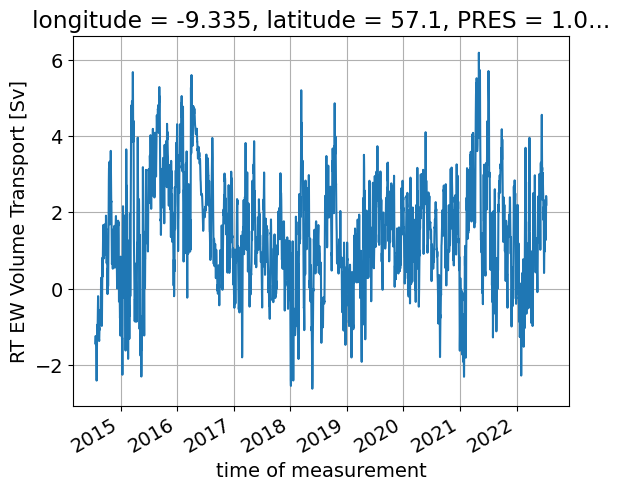

In [20]:
Q_EW.where(Q_EW.mask_EW).plot()
plt.grid()

## Ekman transport

In [21]:
ds_ERA_MB = ds_ERA5[['metss','mntss']].interp(longitude=lon_MB, latitude=lat_MB).drop(['longitude','latitude'])
ds_ERA_MB.coords['lon_MB']=lon_MB
ds_ERA_WW = ds_ERA5[['metss','mntss']].interp(longitude=lon_WW, latitude=lat_WW).drop(['longitude','latitude'])
ds_ERA_WW.coords['lon_WW']=lon_WW
ds_ERA_EW = ds_ERA5[['metss','mntss']].interp(longitude=lon_EW, latitude= lat_EW).drop(['longitude','latitude'])
ds_ERA_EW.coords['lon_EW']=lon_EW

# Get normal and tangent to each section
def tau_rot(ds,lat,lon):
    (_,pa) = np.radians(sw.dist(lat[:2],lon[:2],'km'))
    tau_rot = np.cos(pa)*ds.metss + np.sin(pa)*ds.mntss
    return tau_rot

# Get tau tangent to section
tau_para_MB = tau_rot(ds_ERA_MB,lat_MB,lon_MB)
tau_para_WW = tau_rot(ds_ERA_WW,lat_WW,lon_WW)
tau_para_EW = tau_rot(ds_ERA_EW,lat_EW,lon_EW)

# Get Ekman
f = 2*rtp.Omega*np.sin(np.radians(ds_RT_loc.lat_RTWB))
V_Ek_WW = -1*tau_para_WW/(f*rtp.rho0)
V_Ek_MB = -1*tau_para_MB/(f*rtp.rho0)
V_Ek_EW = -1*tau_para_EW/(f*rtp.rho0)

# Transport per cell in Sv
q_Ek_WW = V_Ek_WW*dx_WW/1e6
q_Ek_MB = V_Ek_MB*dx_MB/1e6
q_Ek_EW = V_Ek_EW*dx_EW/1e6

# Integrate transport timeseries
Q_Ek_WW = q_Ek_WW.sum('lon_WW')
Q_Ek_WW.attrs['name']= 'Q_Ek_WW'
Q_Ek_WW.attrs['long_name']= 'RT WW Ekman Transport'
Q_Ek_WW.attrs['units']='Sv'
Q_Ek_WW.attrs['description']= 'Ekman Transport at wester wedge of Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_MB = q_Ek_MB.sum('lon_MB')
Q_Ek_MB.attrs['name']= 'Q_Ek_MB'
Q_Ek_MB.attrs['long_name']= 'RT MB Ekman Transport'
Q_Ek_MB.attrs['units']='Sv'
Q_Ek_MB.attrs['description']= 'Ekman Transport across Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_EW = q_Ek_EW.sum('lon_EW')
Q_Ek_EW.attrs['name']= 'Q_Ek_EW'
Q_Ek_EW.attrs['long_name']= 'RT EW Ekman Transport'
Q_Ek_EW.attrs['units']='Sv'
Q_Ek_EW.attrs['description']= 'Ekman Transport at eastern wedge of Rockall Trough'\
' derived from ERA5 monthly data'

# Merge to dataset
RT_Q_Ek = xr.merge([Q_Ek_WW.rename(Q_Ek_WW.attrs['name']),
                Q_Ek_MB.rename(Q_Ek_MB.attrs['name']),
                Q_Ek_EW.rename(Q_Ek_EW.attrs['name'])])

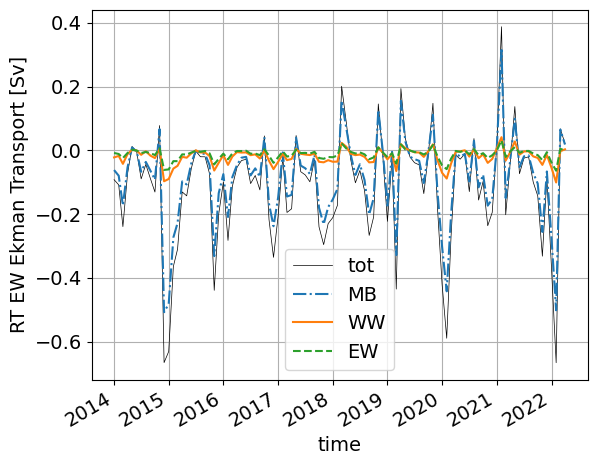

In [22]:
(RT_Q_Ek.Q_Ek_WW+RT_Q_Ek.Q_Ek_MB+RT_Q_Ek.Q_Ek_EW).plot(lw=.5,color='k',label='tot')
RT_Q_Ek.Q_Ek_MB.plot.line(ls='-.',label='MB')
RT_Q_Ek.Q_Ek_WW.plot.line(ls='-',label='WW')
RT_Q_Ek.Q_Ek_EW.plot.line(ls='--',label='EW')
plt.grid()
plt.legend()

## Heat and Freshwater Fluxes

In [23]:
# Get SA and CT fields - interpolate for midbasin
ds_RT['SG_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
ds_RT['TG_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

# Compute fluxes in each cell
qh_EW = rtp.rhoCp*q_EW*(ds_RT.TG_EAST - rtp.CT_ref)
qh_MB = rtp.rhoCp*q_MB*(ds_RT.TG_MB - rtp.CT_ref)
qh_WW = rtp.rhoCp*q_WW*(ds_RT.TG_WEST - rtp.CT_ref)
qf_EW = -1*q_EW*(ds_RT.SG_EAST - rtp.SA_ref)/rtp.SA_ref
qf_MB = -1*q_MB*(ds_RT.SG_MB - rtp.SA_ref)/rtp.SA_ref;
qf_WW = -1*q_WW*(ds_RT.SG_WEST - rtp.SA_ref)/rtp.SA_ref
qS_EW = q_EW*ds_RT.SG_EAST/1027.4
qS_MB = q_MB*ds_RT.SG_MB/1027.4;
qS_WW = q_WW*ds_RT.SG_WEST/1027.4

# % Integrate for timeseries (PW and Sv)
Qh_WW = qh_WW.sum(['depth','lon_WW'])/1e15
Qh_MB = qh_MB.sum(['depth',])/1e15
Qh_EW = qh_EW.sum(['depth','lon_EW'])/1e15
Qf_WW = qf_WW.sum(['depth','lon_WW'])/1e6
Qf_MB = qf_MB.sum(['depth',])/1e6
Qf_EW = qf_EW.sum(['depth','lon_EW'])/1e6
QS_WW = qS_WW.sum(['depth','lon_WW'])/1e3
QS_MB = qS_MB.sum(['depth',])/1e3
QS_EW = qS_EW.sum(['depth','lon_EW'])/1e3

In [24]:
## set attributes
Qh_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW.attrs['name']= 'RT_Qh_EW'
Qh_EW.attrs['long_name']= 'RT EW Heat Flux'
Qh_EW.attrs['units']='PW'
Qh_EW.attrs['description']='Heat flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {rtp.CT_ref}degC'
Qh_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh_WW.attrs['name']= 'RT_Qh_WW'
Qh_WW.attrs['long_name']= 'RT WW Heat Flux'
Qh_WW.attrs['units']='PW'
Qh_WW.attrs['description']='Heat flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {rtp.CT_ref}degC'
Qh_MB.attrs['name']= 'RT_Qh_MB'
Qh_MB.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB.attrs['units']='PW'
Qh_MB.attrs['description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {rtp.CT_ref}degC'

Qf_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW.attrs['name']= 'RT_Qf_EW'
Qf_EW.attrs['long_name']= 'RT EW Freshwater flux'
Qf_EW.attrs['units']='PW'
Qf_EW.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'
Qf_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf_WW.attrs['name']= 'RT_Qf_WW'
Qf_WW.attrs['long_name']= 'RT WW Freshwater Flux'
Qf_WW.attrs['units']='PW'
Qf_WW.attrs['description']='Freshwater flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'
Qf_MB.attrs['name']= 'RT_Qf_MB'
Qf_MB.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB.attrs['units']='PW'
Qf_MB.attrs['description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'

QS_EW.coords['mask_EW'] = Q_EW.mask_EW
QS_EW.attrs['name']= 'RT_QS_EW'
QS_EW.attrs['long_name']= 'RT EW salt flux'
QS_EW.attrs['units']='PW'
QS_EW.attrs['description']='salt flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS_WW.coords['mask_WW'] = Q_WW.mask_WW
QS_WW.attrs['name']= 'RT_QS_WW'
QS_WW.attrs['long_name']= 'RT WW salt Flux'
QS_WW.attrs['units']='PW'
QS_WW.attrs['description']='salt flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS_MB.attrs['name']= 'RT_QS_MB'
QS_MB.attrs['long_name']= 'RT MB salt Flux'
QS_MB.attrs['units']='PW'
QS_MB.attrs['description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [25]:
# finter grid MB
# Compute fluxes in each cell
qh_MB_grid = rtp.rhoCp*ds_RT_MB_grid.q*(ds_RT_MB_grid.CT - rtp.CT_ref)
qf_MB_grid = -1*ds_RT_MB_grid.q*(ds_RT_MB_grid.SA - rtp.SA_ref)/rtp.SA_ref
qS_MB_grid = ds_RT_MB_grid.q*ds_RT_MB_grid.SA/1027.4

# % Integrate for timeseries (PW and Sv)
Q_MB_grid = ds_RT_MB_grid.q.sum(['depth','lon_MB'],min_count=1)/1e6
Qh_MB_grid = qh_MB_grid.sum(['depth','lon_MB'])/1e15
Qf_MB_grid = qf_MB_grid.sum(['depth','lon_MB'])/1e6
QS_MB_grid = qS_MB_grid.sum(['depth','lon_MB'])/1e3

# Integrate for transport timeseries (Sv)
Q_MB_grid.attrs['name']= 'RT_Q_MB'
Q_MB_grid.attrs['long_name']= 'RT MB Volume Transport'
Q_MB_grid.attrs['units']='Sv'
Q_MB_grid.attrs['description']='Mid basin volume transport in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2'\
f' T and S profiles were interpolated on a {rtp.NX_MB}-point horizontal grid before calulation.'

## set attributes
Qh_MB_grid.attrs['name']= 'RT_Qh_MB'
Qh_MB_grid.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB_grid.attrs['units']='PW'
Qh_MB_grid.attrs['description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2'\
f' T and S profiles were interpolated on a {rtp.NX_MB}-cell points horizontal grid before calulation.'\
f' Reference conservative temperature {rtp.CT_ref}degC'

Qf_MB_grid.attrs['name']= 'RT_Qf_MB'
Qf_MB_grid.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB_grid.attrs['units']='PW'
Qf_MB_grid.attrs['description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' T and S profiles were interpolated on a {rtp.NX_MB}-cell points horizontal grid before calulation.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'

QS_MB_grid.attrs['name']= 'RT_QS_MB'
QS_MB_grid.attrs['long_name']= 'RT MB salt Flux'
QS_MB_grid.attrs['units']='PW'
QS_MB_grid.attrs['description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' T and S profiles were interpolated on a {rtp.NX_MB}-cell points horizontal grid before calulation.'\
f' Reference density 1027.4 (kg/m^3)'

In [26]:
# upper 1000 EW, glider comparison
tlim_glider = ['2020-04-10','2020-08-06']
Qh_EW_1000 = qh_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e15
Qf_EW_1000 = qf_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e6

Qh_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW_1000.attrs['name']= 'RT_Qh_EW_1000'
Qh_EW_1000.attrs['long_name']= 'RT EW Heat Flux for upper 1000m'
Qh_EW_1000.attrs['units']='PW'
Qh_EW_1000.attrs['description']='Heat flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {rtp.CT_ref}degC'

Qf_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW_1000.attrs['name']= 'RT_Qf_EW_1000'
Qf_EW_1000.attrs['long_name']= 'RT EW Freshwater flux for upper 1000m'
Qf_EW_1000.attrs['units']='PW'
Qf_EW_1000.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'

In [27]:
# isolate tracer vs vel part

# Compute fluxes in each cell
qh1_EW = rtp.rhoCp*q_EW*(ds_RT.TG_EAST.mean('TIME') - rtp.CT_ref)
qh1_MB = rtp.rhoCp*q_MB*(ds_RT.TG_MB.mean('TIME') - rtp.CT_ref)
qh1_WW = rtp.rhoCp*q_WW*(ds_RT.TG_WEST.mean('TIME') - rtp.CT_ref)
qf1_EW = -1*q_EW*(ds_RT.SG_EAST.mean('TIME') - rtp.SA_ref)/rtp.SA_ref
qf1_MB = -1*q_MB*(ds_RT.SG_MB.mean('TIME') - rtp.SA_ref)/rtp.SA_ref
qf1_WW = -1*q_WW*(ds_RT.SG_WEST.mean('TIME') - rtp.SA_ref)/rtp.SA_ref
qS1_EW = q_EW*ds_RT.SG_EAST.mean('TIME')/1027.4
qS1_MB = q_MB*ds_RT.SG_MB.mean('TIME')/1027.4
qS1_WW = q_WW*ds_RT.SG_WEST.mean('TIME')/1027.4

qh2_EW = rtp.rhoCp*q_EW.mean('TIME')*(ds_RT.TG_EAST - rtp.CT_ref)
qh2_MB = rtp.rhoCp*q_MB.mean('TIME')*(ds_RT.TG_MB - rtp.CT_ref)
qh2_WW = rtp.rhoCp*q_WW.mean('TIME')*(ds_RT.TG_WEST - rtp.CT_ref)
qf2_EW = -1*q_EW.mean('TIME')*(ds_RT.SG_EAST - rtp.SA_ref)/rtp.SA_ref
qf2_MB = -1*q_MB.mean('TIME')*(ds_RT.SG_MB - rtp.SA_ref)/rtp.SA_ref
qf2_WW = -1*q_WW.mean('TIME')*(ds_RT.SG_WEST - rtp.SA_ref)/rtp.SA_ref
qS2_EW = q_EW.mean('TIME')*ds_RT.SG_EAST/1027.4
qS2_MB = q_MB.mean('TIME')*ds_RT.SG_MB/1027.4
qS2_WW = q_WW.mean('TIME')*ds_RT.SG_WEST/1027.4

# % Integrate for timeseries (PW and Sv)
Qh1_WW = qh1_WW.sum(['depth','lon_WW'])/1e15
Qh1_MB = qh1_MB.sum('depth')/1e15
Qh1_EW = qh1_EW.sum(['depth','lon_EW'])/1e15
Qf1_WW = qf1_WW.sum(['depth','lon_WW'])/1e6
Qf1_MB = qf1_MB.sum('depth')/1e6
Qf1_EW = qf1_EW.sum(['depth','lon_EW'])/1e6
QS1_WW = qS1_WW.sum(['depth','lon_WW'])/1e3
QS1_MB = qS1_MB.sum('depth')/1e3
QS1_EW = qS1_EW.sum(['depth','lon_EW'])/1e3

Qh2_WW = qh2_WW.sum(['depth','lon_WW'])/1e15
Qh2_MB = qh2_MB.sum('depth')/1e15
Qh2_EW = qh2_EW.sum(['depth','lon_EW'])/1e15
Qf2_WW = qf2_WW.sum(['depth','lon_WW'])/1e6
Qf2_MB = qf2_MB.sum('depth')/1e6
Qf2_EW = qf2_EW.sum(['depth','lon_EW'])/1e6
QS2_WW = qS2_WW.sum(['depth','lon_WW'])/1e3
QS2_MB = qS2_MB.sum('depth')/1e3
QS2_EW = qS2_EW.sum(['depth','lon_EW'])/1e3

Qh1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf1_EW.coords['mask_EW'] = Q_EW.mask_EW
QS1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh2_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf2_EW.coords['mask_EW'] = Q_EW.mask_EW
QS2_EW.coords['mask_EW'] = Q_EW.mask_EW

Qh1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf1_WW.coords['mask_WW'] = Q_WW.mask_WW
QS1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh2_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf2_WW.coords['mask_WW'] = Q_WW.mask_WW
QS2_WW.coords['mask_WW'] = Q_WW.mask_WW

In [28]:
Qh1_EW.attrs['name']= 'RT_Qh_EW_Tfix'
Qh1_EW.attrs['long_name']= 'RT EW Heat Flux Tfix'
Qh1_EW.attrs['units']='PW'
Qh1_EW.attrs['description']='Heat flux at eastern wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {rtp.CT_ref}degC'
Qh1_WW.attrs['name']= 'RT_Qh_WW_Tfix'
Qh1_WW.attrs['long_name']= 'RT WW Heat Flux Tfix'
Qh1_WW.attrs['units']='PW'
Qh1_WW.attrs['description']='Heat flux at western wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {rtp.CT_ref}degC'
Qh1_MB.attrs['name']= 'RT_Qh_MB_Tfix'
Qh1_MB.attrs['long_name']= 'RT MB Heat Flux Tfix'
Qh1_MB.attrs['units']='PW'
Qh1_MB.attrs['description']='Mid basin heat flux in Rockall Trough using temporal mean temperature profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {rtp.CT_ref}degC'

Qf1_EW.attrs['name']= 'RT_Qf_EW_Sfix'
Qf1_EW.attrs['long_name']= 'RT EW Freshwater flux_Sfix'
Qf1_EW.attrs['units']='PW'
Qf1_EW.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'
Qf1_WW.attrs['name']= 'RT_Qf_WW_Sfix'
Qf1_WW.attrs['long_name']= 'RT WW Freshwater Flux_Sfix'
Qf1_WW.attrs['units']='PW'
Qf1_WW.attrs['description']='Freshwater flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'
Qf1_MB.attrs['name']= 'RT_Qf_MB_Sfix'
Qf1_MB.attrs['long_name']= 'RT MB Freshwater Flux_Sfix'
Qf1_MB.attrs['units']='PW'
Qf1_MB.attrs['description']='Mid basin freshwater flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'

QS1_EW.attrs['name']= 'RT_QS_EW_Sfix'
QS1_EW.attrs['long_name']= 'RT EW salt flux_Sfix'
QS1_EW.attrs['units']='PW'
QS1_EW.attrs['description']='salt flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_WW.attrs['name']= 'RT_QS_WW_Sfix'
QS1_WW.attrs['long_name']= 'RT WW salt Flux_Sfix'
QS1_WW.attrs['units']='PW'
QS1_WW.attrs['description']='salt flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_MB.attrs['name']= 'RT_QS_MB_Sfix'
QS1_MB.attrs['long_name']= 'RT MB salt Flux_Sfix'
QS1_MB.attrs['units']='PW'
QS1_MB.attrs['description']='Mid basin salt flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [29]:
Qh2_EW.attrs['name']= 'RT_Qh_EW_qfix'
Qh2_EW.attrs['long_name']= 'RT EW Heat Flux qfix'
Qh2_EW.attrs['units']='PW'
Qh2_EW.attrs['description']='Heat flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {rtp.CT_ref}degC'
Qh2_WW.attrs['name']= 'RT_Qh_WW_qfix'
Qh2_WW.attrs['long_name']= 'RT WW Heat Flux qfix'
Qh2_WW.attrs['units']='PW'
Qh2_WW.attrs['description']='Heat flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {rtp.CT_ref}degC'
Qh2_MB.attrs['name']= 'RT_Qh_MB_qfix'
Qh2_MB.attrs['long_name']= 'RT MB Heat Flux qfix'
Qh2_MB.attrs['units']='PW'
Qh2_MB.attrs['description']='Mid basin heat flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {rtp.CT_ref}degC'

Qf2_EW.attrs['name']= 'RT_Qf_EW_qfix'
Qf2_EW.attrs['long_name']= 'RT EW Freshwater flux_qfix'
Qf2_EW.attrs['units']='PW'
Qf2_EW.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'
Qf2_WW.attrs['name']= 'RT_Qf_WW_qfix'
Qf2_WW.attrs['long_name']= 'RT WW Freshwater Flux_qfix'
Qf2_WW.attrs['units']='PW'
Qf2_WW.attrs['description']='Freshwater flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'
Qf2_MB.attrs['name']= 'RT_Qf_MB_qfix'
Qf2_MB.attrs['long_name']= 'RT MB Freshwater Flux_qfix'
Qf2_MB.attrs['units']='PW'
Qf2_MB.attrs['description']='Mid basin freshwater flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {rtp.SA_ref} (g/kg)'

QS2_EW.attrs['name']= 'RT_QS_EW_qfix'
QS2_EW.attrs['long_name']= 'RT EW salt flux_qfix'
QS2_EW.attrs['units']='PW'
QS2_EW.attrs['description']='salt flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_WW.attrs['name']= 'RT_QS_WW_qfix'
QS2_WW.attrs['long_name']= 'RT WW salt Flux_qfix'
QS2_WW.attrs['units']='PW'
QS2_WW.attrs['description']='salt flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_MB.attrs['name']= 'RT_QS_MB_qfix'
QS2_MB.attrs['long_name']= 'RT MB salt Flux_qfix'
QS2_MB.attrs['units']='PW'
QS2_MB.attrs['description']='Mid basin salt flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [30]:
#low pass filter
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/rtp.filter_length # cut off frequency
with xr.set_options(keep_attrs=True):
    # Transports
    Q_MB_lp = rtf.lazy_butter_lp_filter(Q_MB,lowcut,fs,dim='TIME')
    Q_MB_grid_lp = rtf.lazy_butter_lp_filter(Q_MB_grid,lowcut,fs,dim='TIME')
    Q_MB_SAfix = rtf.lazy_butter_lp_filter(Q_MB_SAfix,lowcut,fs,dim='TIME')
    Q_MB_CTfix = rtf.lazy_butter_lp_filter(Q_MB_CTfix,lowcut,fs,dim='TIME')
    Q_MB_SAfix_CTfix = rtf.lazy_butter_lp_filter(Q_MB_SAfix_CTfix,lowcut,fs,dim='TIME')
    Q_MB_WB_CTvar = rtf.lazy_butter_lp_filter(Q_MB_WB_CTvar,lowcut,fs,dim='TIME')
    Q_MB_EB_CTvar = rtf.lazy_butter_lp_filter(Q_MB_EB_CTvar,lowcut,fs,dim='TIME')
    Q_WW_lp = rtf.lazy_butter_lp_filter(Q_WW.fillna(0),lowcut,fs,dim='TIME')
    Q_WW_lp = Q_WW_lp.where(Q_WW.notnull())
    Q_EW_lp = rtf.lazy_butter_lp_filter(Q_EW.fillna(0),lowcut,fs,dim='TIME')
    Q_EW_lp = Q_EW_lp.where(Q_EW.notnull())

    # Heat flux
    Qh_MB_lp = rtf.lazy_butter_lp_filter(Qh_MB,lowcut,fs,dim='TIME')
    Qh_MB_grid_lp = rtf.lazy_butter_lp_filter(Qh_MB_grid,lowcut,fs,dim='TIME')
    Qh_WW_lp = rtf.lazy_butter_lp_filter(Qh_WW,lowcut,fs,dim='TIME')
    Qh_EW_lp = rtf.lazy_butter_lp_filter(Qh_EW,lowcut,fs,dim='TIME')
    Qh1_MB_lp = rtf.lazy_butter_lp_filter(Qh1_MB,lowcut,fs,dim='TIME')
    Qh1_WW_lp = rtf.lazy_butter_lp_filter(Qh1_WW,lowcut,fs,dim='TIME')
    Qh1_EW_lp = rtf.lazy_butter_lp_filter(Qh1_EW,lowcut,fs,dim='TIME')
    Qh2_MB_lp = rtf.lazy_butter_lp_filter(Qh2_MB,lowcut,fs,dim='TIME')
    Qh2_WW_lp = rtf.lazy_butter_lp_filter(Qh2_WW,lowcut,fs,dim='TIME')
    Qh2_EW_lp = rtf.lazy_butter_lp_filter(Qh2_EW,lowcut,fs,dim='TIME')

    # Freshwater flux
    Qf_MB_lp = rtf.lazy_butter_lp_filter(Qf_MB,lowcut,fs,dim='TIME')
    Qf_MB_grid_lp = rtf.lazy_butter_lp_filter(Qf_MB_grid,lowcut,fs,dim='TIME')
    Qf_WW_lp = rtf.lazy_butter_lp_filter(Qf_WW,lowcut,fs,dim='TIME')
    Qf_EW_lp = rtf.lazy_butter_lp_filter(Qf_EW,lowcut,fs,dim='TIME')
    Qf1_MB_lp = rtf.lazy_butter_lp_filter(Qf1_MB,lowcut,fs,dim='TIME')
    Qf1_WW_lp = rtf.lazy_butter_lp_filter(Qf1_WW,lowcut,fs,dim='TIME')
    Qf1_EW_lp = rtf.lazy_butter_lp_filter(Qf1_EW,lowcut,fs,dim='TIME')
    Qf2_MB_lp = rtf.lazy_butter_lp_filter(Qf2_MB,lowcut,fs,dim='TIME')
    Qf2_WW_lp = rtf.lazy_butter_lp_filter(Qf2_WW,lowcut,fs,dim='TIME')
    Qf2_EW_lp = rtf.lazy_butter_lp_filter(Qf2_EW,lowcut,fs,dim='TIME')
    
    # Salt flux
    QS_MB_lp = rtf.lazy_butter_lp_filter(QS_MB,lowcut,fs,dim='TIME')
    QS_MB_grid_lp = rtf.lazy_butter_lp_filter(QS_MB_grid,lowcut,fs,dim='TIME')
    QS_WW_lp = rtf.lazy_butter_lp_filter(QS_WW,lowcut,fs,dim='TIME')
    QS_EW_lp = rtf.lazy_butter_lp_filter(QS_EW,lowcut,fs,dim='TIME')
    QS1_MB_lp = rtf.lazy_butter_lp_filter(QS1_MB,lowcut,fs,dim='TIME')
    QS1_WW_lp = rtf.lazy_butter_lp_filter(QS1_WW,lowcut,fs,dim='TIME')
    QS1_EW_lp = rtf.lazy_butter_lp_filter(QS1_EW,lowcut,fs,dim='TIME')
    QS2_MB_lp = rtf.lazy_butter_lp_filter(QS2_MB,lowcut,fs,dim='TIME')
    QS2_WW_lp = rtf.lazy_butter_lp_filter(QS2_WW,lowcut,fs,dim='TIME')
    QS2_EW_lp = rtf.lazy_butter_lp_filter(QS2_EW,lowcut,fs,dim='TIME')

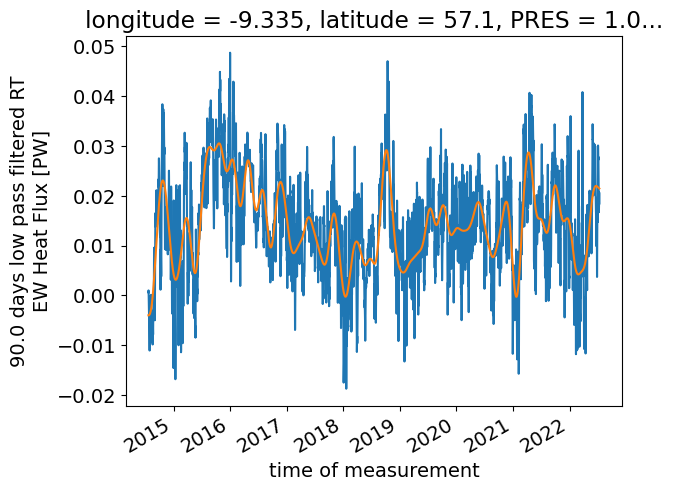

In [31]:
Qh_EW.where(Qh_EW.mask_EW).plot()
Qh_EW_lp.where(Qh_EW.mask_EW).plot()

### Get depth-accumulated transport

In [32]:
qz_EW = q_EW.sum('lon_EW')
qz_WW = q_WW.sum('lon_WW')
qz_MB = q_MB
qz_MB_grid = q_MB_grid.sum('lon_MB')
Q_MB_cumul = qz_MB.sel(depth=slice(None,P_ref))/1e6
Q_MB_grid_cumul = qz_MB_grid.sel(depth=slice(None,P_ref))/1e6
Q_EW_cumul = qz_EW.sel(depth=slice(None,P_ref))/1e6
Q_WW_cumul = qz_WW.sel(depth=slice(None,P_ref))/1e6

### Standard errors

In [33]:
# transport
SEw = rtf.std_error(Q_WW)
SEm = rtf.std_error(Q_MB)
SEm_grid = rtf.std_error(Q_MB_grid)
SEe = rtf.std_error(Q_EW)
SE = rtf.std_error((Q_WW.fillna(0) + Q_MB + Q_EW.fillna(0)))

# HF
SEhw = rtf.std_error(Qh_WW)
SEhm = rtf.std_error(Qh_MB)
SEhm_grid = rtf.std_error(Qh_MB_grid)
SEhe = rtf.std_error(Qh_EW)
SEh = rtf.std_error((Qh_WW.fillna(0) + Qh_MB + Qh_EW.fillna(0)))

# FF
SEfw = rtf.std_error(Qf_WW)
SEfm = rtf.std_error(Qf_MB)
SEfm_grid = rtf.std_error(Qf_MB_grid)
SEfe = rtf.std_error(Qf_EW)
SEf = rtf.std_error((Qf_WW.fillna(0) + Qf_MB + Qf_EW.fillna(0)))

'x has 5827 data cycles'

'Integral time scale (days) = 67.42689151570991'

' : Degrees of freedom = 86.419525934135'

'x has 5827 data cycles'

'Integral time scale (days) = 137.9383584441073'

' : Degrees of freedom = 42.24350692386341'

'x has 5827 data cycles'

'Integral time scale (days) = 137.93835844410734'

' : Degrees of freedom = 42.2435069238634'

'x has 5827 data cycles'

'Integral time scale (days) = 134.94889683114224'

' : Degrees of freedom = 43.17930814426117'

'x has 5827 data cycles'

'Integral time scale (days) = 137.89652317593468'

' : Degrees of freedom = 42.25632282668685'

'x has 5827 data cycles'

'Integral time scale (days) = 60.90982041208049'

' : Degrees of freedom = 95.66601839535727'

'x has 5827 data cycles'

'Integral time scale (days) = 136.15043570487265'

' : Degrees of freedom = 42.79824717293548'

'x has 5827 data cycles'

'Integral time scale (days) = 136.04476584599345'

' : Degrees of freedom = 42.83148979503063'

'x has 5827 data cycles'

'Integral time scale (days) = 127.24726771235225'

' : Degrees of freedom = 45.79273177929585'

'x has 5827 data cycles'

'Integral time scale (days) = 125.94696549986526'

' : Degrees of freedom = 46.265505301167686'

'x has 5827 data cycles'

'Integral time scale (days) = 63.5495475982071'

' : Degrees of freedom = 91.69223417358198'

'x has 5827 data cycles'

'Integral time scale (days) = 396.897790340279'

' : Degrees of freedom = 14.681361654858902'

'x has 5827 data cycles'

'Integral time scale (days) = 396.16388655987527'

' : Degrees of freedom = 14.70855925460364'

'x has 5827 data cycles'

'Integral time scale (days) = 221.60091898551337'

' : Degrees of freedom = 26.295017307130056'

'x has 5827 data cycles'

'Integral time scale (days) = 321.72555580858995'

' : Degrees of freedom = 18.111710104455497'

In [34]:
print('tot transport errors')
print(SE.values)
print(SEh.values)
print(SEf.values)

print('Midbasin non-grid')
print(SEm.values)
print(SEhm.values)
print(SEfm.values)


print('Midbasin .grid')
print(SEm_grid.values)
print(SEhm_grid.values)
print(SEfm_grid.values)

tot transport errors
0.5273514851442234
0.003718033182388076
0.0026477094203814174
Midbasin non-grid
0.48292017572269225
0.0033524562888948397
0.0027763055156918327
Midbasin .grid
0.48292017572269225
0.0033624433447642563
0.0027843437063536955


# tot transports


### Add attributes to tot transport timeseries

In [35]:
Q_tot = Q_WW.fillna(0)+Q_EW.fillna(0)+Q_MB
Q_tot_lp = Q_WW_lp.fillna(0) + Q_MB_lp + Q_EW_lp.fillna(0)

Qh_tot = Qh_WW.fillna(0)+Qh_EW.fillna(0)+Qh_MB
Qh_tot_lp = Qh_WW_lp.fillna(0) + Qh_MB_lp + Qh_EW_lp.fillna(0)

Qf_tot = Qf_WW.fillna(0)+Qf_EW.fillna(0)+Qf_MB
Qf_tot_lp = Qf_WW_lp.fillna(0) + Qf_MB_lp + Qf_EW_lp.fillna(0)


Q_tot.coords['mask']=(Q_tot.mask_EW+Q_tot.mask_WW)
Q_tot = Q_tot.where(Q_tot.mask).compute()
Q_tot_lp = Q_tot_lp.where(Q_tot.mask).compute()

Qh_tot = Qh_tot.where(Q_tot.mask).compute()
Qh_tot_lp = Qh_tot_lp.where(Q_tot.mask).compute()

Qf_tot = Qf_tot.where(Q_tot.mask).compute()
Qf_tot_lp = Qf_tot_lp.where(Q_tot.mask).compute()

In [36]:
units = 'Sv'
name = 'sum of western, eastern, and mid-basin volume transport'
Q_tot.attrs = dict(long_name=name, units=units)
Q_tot_lp.attrs = dict(long_name=f'{1/lowcut} days low pass filtered {name}', units=units)

units = 'PW'
name = 'sum of western, eastern, and mid-basin freshwater transport'
Qh_tot.attrs = dict(long_name=name, units=units)
Qh_tot_lp.attrs = dict(long_name=f'{1/lowcut} days low pass filtered {name}', units=units)

units ='Sv'
name = 'sum of western, eastern, and mid-basin freshwater transport'
Qf_tot.attrs = dict(long_name=name, units=units)
Qf_tot_lp.attrs = dict(long_name=f'{1/lowcut} days low pass filtered {name}', units=units)

### Standard error pre 2017 - check regime shift

In [37]:
SE_pre_2017 = rtf.std_error(Q_tot.sel(TIME=slice(None,'2017')))
SEh_pre_2017 = rtf.std_error(Qh_tot.sel(TIME=slice(None,'2017')))
SEf_pre_2017 = rtf.std_error(Qf_tot.sel(TIME=slice(None,'2017')))

SE_after_2017 = rtf.std_error(Q_tot.sel(TIME=slice('2017',None)))
SEh_after_2017 = rtf.std_error(Qh_tot.sel(TIME=slice('2017',None)))
SEf_after_2017 = rtf.std_error(Qf_tot.sel(TIME=slice('2017',None)))

Q=Q_tot.sel(TIME=slice(None,'2017'))
print(f"Q Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_tot.sel(TIME=slice(None,'2017'))
print(f"Qh Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_tot.sel(TIME=slice(None,'2017'))
print(f"Qf Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")


'x has 2519 data cycles'

'Integral time scale (days) = 168.6555797537709'

' : Degrees of freedom = 14.935764376592935'

'x has 2519 data cycles'

'Integral time scale (days) = 129.70493427143845'

' : Degrees of freedom = 19.421003635284936'

'x has 2519 data cycles'

'Integral time scale (days) = 332.5958571291064'

' : Degrees of freedom = 7.5737563953545575'

'x has 4038 data cycles'

'Integral time scale (days) = 132.18407341197883'

' : Degrees of freedom = 30.548309609242736'

'x has 4038 data cycles'

'Integral time scale (days) = 123.03491945501159'

' : Degrees of freedom = 32.81995077402816'

'x has 4038 data cycles'

'Integral time scale (days) = 146.15554719540728'

' : Degrees of freedom = 27.628099497320264'

Q Pre 2017 mean is 5.017083214929473, std dev is 3.6246081606777127, std error is 0.9378801345840168
Qh Pre 2017 mean is 0.051919667279889885, std dev is 0.025934965095035213, std error is 0.005885045610184164
Qf Pre 2017 mean is -0.023294138827259208, std dev is 0.012649711193190026, std error is 0.004596475441746287


In [38]:
Q=Q_tot.sel(TIME=slice('2017',None))
print(f"Q after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_tot.sel(TIME=slice('2017',None))
print(f"Qh after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_tot.sel(TIME=slice('2017',None))
print(f"Qf after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")

Q after 2017 mean is 4.265708851886659, std dev is 3.367637714926044, std error is 0.9378801345840168
Qh after 2017 mean is 0.0439947057279632, std dev is 0.024959542665425917, std error is 0.005885045610184164
Qf after 2017 mean is -0.01695117319830102, std dev is 0.009579421962910267, std error is 0.004596475441746287


### Check trends in time-series

In [39]:
dim = 'TIME'
fit, slope, intc, trend_significant = rtf.detrend_data(Q_tot,dim)

'x has 5827 data cycles'

'Integral time scale (days) = 137.89652317593422'

' : Degrees of freedom = 42.25632282668698'

# Prepare data to save

In [40]:
SE.attrs = {'name':'SE_Q_tot',
            'long_name':'Standard error',
            'description':'Standard error of total volume transport Q_tot, Rockall Trough',
             'units':'Sv'}
SEe.attrs = {'name':'SE_Q_EW',
            'long_name':'Standard error',
            'description':'Standard error of volume transport Q_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEm.attrs = {'name':'SE_Q_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin volume transport Q_MB of Rockall Trough',
             'units':'Sv'}
SEw.attrs = {'name':'SE_Q_WW',
            'long_name':'Standard error',
            'description':'Standard error of volume transport Q_WW at western wedge of Rockall Trough',
             'units':'Sv'}

SEh.attrs = {'name':'SE_Qh_tot',
            'long_name':'Standard error',
            'description':'Standard error of total heat transport Qh_tot, Rockall Trough',
             'units':'PW'}
SEhe.attrs = {'name':'SE_Qh_EW',
            'long_name':'Standard error',
            'description':'Standard error of heat transport Qh_EW at eastern wedge of Rockall Trough',
             'units':'PW'}
SEhm.attrs = {'name':'SE_Qh_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin heat transport Qh_MB of Rockall Trough',
             'units':'PW'}
SEhw.attrs = {'name':'SE_Qh_WW',
            'long_name':'Standard error',
            'description':'Standard error of heat transport Qh_WW at western wedge of Rockall Trough',
             'units':'PW'}

SEf.attrs = {'name':'SE_Qf_tot',
            'long_name':'Standard error',
            'description':'Standard error of total freshwater transport Qf_tot, Rockall Trough',
             'units':'Sv'}
SEfe.attrs = {'name':'SE_Qf_EW',
            'long_name':'Standard error',
            'description':'Standard error of freshwater transport Qf_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEfm.attrs = {'name':'SE_Qf_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin freshwater transport Qf_MB of Rockall Trough',
             'units':'Sv'}
SEfw.attrs = {'name':'SE_Qf_WW',
            'long_name':'Standard error',
            'description':'Standard error of freshwater transport Qf_WW at western wedge of Rockall Trough',
             'units':'Sv'}

In [41]:
RT_Q_Qh_Qf = xr.merge([Q_tot.rename('Q_tot'),Q_tot_lp.rename('Q_tot_lp'),SE.rename('SE_tot'),
          Q_EW.rename('Q_EW'),Q_EW_lp.rename('Q_EW_lp'),SEe.rename('SE_EW'),
          Q_MB.rename('Q_MB'),Q_MB_lp.rename('Q_MB_lp'),SEm.rename('SE_MB'),
          Q_WW.rename('Q_WW'),Q_WW_lp.rename('Q_WW_lp'),SEw.rename('SE_WW'),
          Qh_tot.rename('Qh_tot'),Qh_tot_lp.rename('Qh_tot_lp'),SEh.rename('SEh_tot'),
          Qh_EW.rename('Qh_EW'),Qh_EW_lp.rename('Qh_EW_lp'),SEhe.rename('SEh_EW'),
          Qh_MB.rename('Qh_MB'),Qh_MB_lp.rename('Qh_MB_lp'),SEhm.rename('SEh_MB'),
          Qh_WW.rename('Qh_WW'),Qh_WW_lp.rename('Qh_WW_lp'),SEhw.rename('SEh_WW'),
          Qf_tot.rename('Qf_tot'),Qf_tot_lp.rename('Qf_tot_lp'),SEf.rename('SEf_tot'),
          Qf_EW.rename('Qf_EW'),Qf_EW_lp.rename('Qf_EW_lp'),SEfe.rename('SEf_EW'),
          Qf_MB.rename('Qf_MB'),Qf_MB_lp.rename('Qf_MB_lp'),SEfm.rename('SEf_MB'),
          Qf_WW.rename('Qf_WW'),Qf_WW_lp.rename('Qf_WW_lp'),SEfw.rename('SEf_WW'),
         ]).drop(['PRES','depth','mask_WW','longitude','latitude','time','mask_EW','lat_MB','lon_MB','mask'])
RT_q = xr.merge([q_EW.rename('q_EW').drop(['longitude','latitude','time']),q_MB.rename('q_MB'),q_WW.rename('q_WW')])

In [42]:
date_str_start = '201407'
date_str_end = '202207'
global_attrs = {'title' : f'Rockall Trough transport data {date_str_start[-2:]}/{date_str_start[:-2]}-{date_str_end[-2:]}/{date_str_end[:-2]} v0',
'institution' : 'Scottish Association for Marine Science, Scottish Marine Institute Oban, Argyll, PA37 1QA, UK',
'history' : 'Delayed time processed quality controlled',
'description':'Rockall Trough transport. The timeseries is a extended version of the one published in Fraser et al. (2022, JGR Ocean, see references)',
'id' : f'{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}',
'pi':'Stuart Cunningham',
'creator_name' : 'Kristin Burmeister',
'creator_url' : 'https://orcid.org/0000-0003-3881-0298',
'contributor_name' : 'Neil Fraser, Lewis Drysdale, Sam Jones, Stuart Cunningham',
'source' : 'Derived from moored current meter observations and model analysis and reanalysis from GLORYS12V1',
'project' : 'Climate Linked Atlantic Sector Science',
'references' : 'https://doi.org/10.1029/2022JC019291, http://www.o-snap.org',
'area' : 'North Atlantic Ocean',
'time_coverage_start' : f'{RT_Q_Qh_Qf.TIME.min().dt.strftime("%Y-%m-%d %r").values}',
'time_coverage_end' : f'{RT_Q_Qh_Qf.TIME.max().dt.strftime("%Y-%m-%d %r").values}',
'citation' : 'These data were collected and made freely available by the OSNAP project and the national programs that contribute to it.',
'acknowledgement' : 'Funding source: the UK Natural Environment Research Council (NERC), UK OSNAP project', 
'date_created' : datetime.datetime.now().strftime("%Y-%m-%d %r"),
'date_modified' : datetime.datetime.now().strftime("%Y-%m-%d %r")}
RT_Q_Qh_Qf.attrs = global_attrs

In [43]:
RT_Q_Qh_Qf

<xarray.Dataset>
Dimensions:    (TIME: 5827)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
Data variables: (12/36)
    Q_tot      (TIME) float64 3.827 4.248 4.603 4.268 ... 5.915 5.681 5.313
    Q_tot_lp   (TIME) float64 4.244 4.243 4.242 4.241 ... 4.439 4.445 4.451
    SE_tot     float64 dask.array<chunksize=(), meta=np.ndarray>
    Q_EW       (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    Q_EW_lp    (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    SE_EW      float64 dask.array<chunksize=(), meta=np.ndarray>
    ...         ...
    Qf_MB      (TIME) float64 -0.0335 -0.03403 -0.03439 ... -0.00569 -0.004631
    Qf_MB_lp   (TIME) float64 -0.03322 -0.03323 -0.03324 ... 0.000388 0.0003635
    SEf_MB     float64 0.002776
    Qf_WW      (TIME) float64 0.001183 -0.001102 ... -0.003065 -0.004003
    Qf_WW_lp   (TIME) float64 0.002144 0.002161 0.00218 ... -0.004485 -0.004485
    SEf_WW     float64 0.000716
Attributes: (12/19)
    title:                Rockall Trough transport data 07/2014-07/2022 v0
    institution:          Scottish Association for Marine Science, Scottish M...
    history:              Delayed time processed quality controlled
    description:          Rockall Trough transport. The timeseries is a exten...
    id:                   Rockall_Trough_transport_time_series_201407_202207_v0
    pi:                   Stuart Cunningham
    ...                   ...
    time_coverage_start:  2014-07-21 12:00:00 PM
    time_coverage_end:    2022-07-12 12:00:00 PM
    citation:             These data were collected and made freely available...
    acknowledgement:      Funding source: the UK Natural Environment Research...
    date_created:         2024-04-19 12:32:25 PM
    date_modified:        2024-04-19 12:32:25 PM

In [44]:
ds_q_RTMB = ds_RT_MB_grid.drop('PRES').rename({'TIME':'time'})
ds_q_RTMB = ds_q_RTMB.rename({'lon_MB':'lon','lat_MB':'lat','dx_MB':'dx'})
ds_q_RTMB.coords['dz']=dz
ds_q_RTMB

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 99)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat      (lon) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.11 57.1
  * lon      (lon) float64 -12.49 -12.46 -12.43 -12.4 ... -9.638 -9.609 -9.579
    dx       (lon) float64 1.826e+03 1.826e+03 1.827e+03 ... 1.843e+03 1.843e+03
    PRES     (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (depth, lon, time) float64 826.5 827.8 840.9 848.6 ... nan nan nan
    CT       (lon, time, depth) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (lon, time, depth) float64 35.56 35.56 35.56 35.56 ... nan nan nan
Attributes:
    name:     depth
    units:    m

In [45]:
ds_q_RTEW = xr.Dataset()
ds_q_RTEW['q']=(RT_q.reset_coords().q_EW.rename('q')).rename({'lon_EW':'lon'})
ds_q_RTEW.coords['lat']=RT_q.reset_coords().lat_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dx']=dx_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dz']=dz
mask = ds_q_RTEW.q.notnull()
ds_q_RTEW['CT'] = (ds_RT.TG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW['SA'] = (ds_RT.SG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW = ds_q_RTEW.drop('PRES').rename({'TIME':'time'})

In [46]:
ds_q_RTWW = xr.Dataset()
ds_q_RTWW['q']=(RT_q.reset_coords().q_WW.rename('q')).rename({'lon_WW':'lon'})
ds_q_RTWW.coords['lat']=RT_q.reset_coords().lat_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dx']=dx_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dz']=dz
mask = ds_q_RTWW.q.notnull()
ds_q_RTWW['CT'] = (ds_RT.TG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW['SA'] = (ds_RT.SG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW = ds_q_RTWW.drop('PRES').rename({'TIME':'time'})
ds_q_RTWW

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 100)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
  * lon      (lon) float64 -13.03 -13.03 -13.02 -13.02 ... -12.52 -12.51 -12.51
    lat      (lon) float64 57.47 57.47 57.47 57.47 ... 57.47 57.47 57.47 57.47
    dx       (lon) float64 158.3 316.6 316.6 316.6 ... 316.6 316.6 316.6 158.3
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (lon, depth, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    CT       (time, depth, lon) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (time, depth, lon) float64 35.56 35.56 35.56 35.56 ... nan nan nan

In [47]:
RT_q['dx_EW']=dx_EW
RT_q['dx_WW']=dx_WW
# RT_q['dx_MB']=dx_MB
RT_q['dz']=ds_RT.dz
 
RT_q['SA_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
RT_q['CT_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

mask = RT_q.q_EW.notnull()
RT_q['CT_EW'] = (ds_RT.TG_EAST*RT_q.q_EW.notnull()).where(mask)
RT_q['SA_EW'] = (ds_RT.SG_EAST*RT_q.q_EW.notnull()).where(mask)

mask = RT_q.q_WW.notnull()
RT_q['CT_WW'] = (ds_RT.TG_WEST*RT_q.q_WW.notnull()).where(mask)
RT_q['SA_WW'] = (ds_RT.SG_WEST*RT_q.q_WW.notnull()).where(mask)

In [48]:
RT_Q_Qh_Qf.to_netcdf(f'{data_out_path}/{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_q.to_netcdf(f'{data_out_path}/RT_q_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_Q_Ek.to_netcdf(f'{data_out_path}/RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

In [49]:
ds_q_RTMB.to_netcdf(f'{data_out_path}/q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTWW.to_netcdf(f'{data_out_path}/q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTEW.to_netcdf(f'{data_out_path}/q_RTEW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

In [50]:
RT_Q_Qh_Qf.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
RT_q.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/RT_q_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
RT_Q_Ek.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))

In [51]:
ds_q_RTMB.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
ds_q_RTWW.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
ds_q_RTEW.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/q_RTEW_times_eries_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))

# Plot timeseries

In [52]:
RT_Q_Qh_Qf = xr.open_dataset(f'{data_out_path}{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_q = xr.open_dataset(f'{data_out_path}RT_q_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_Q_Ek = xr.open_dataset(f'{data_out_path}RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

In [53]:
ds_q_RTMB = xr.open_dataset(f'{data_out_path}q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTWW = xr.open_dataset(f'{data_out_path}q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTEW = xr.open_dataset(f'{data_out_path}q_RTEW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

## Rockall Trough Volume Transport

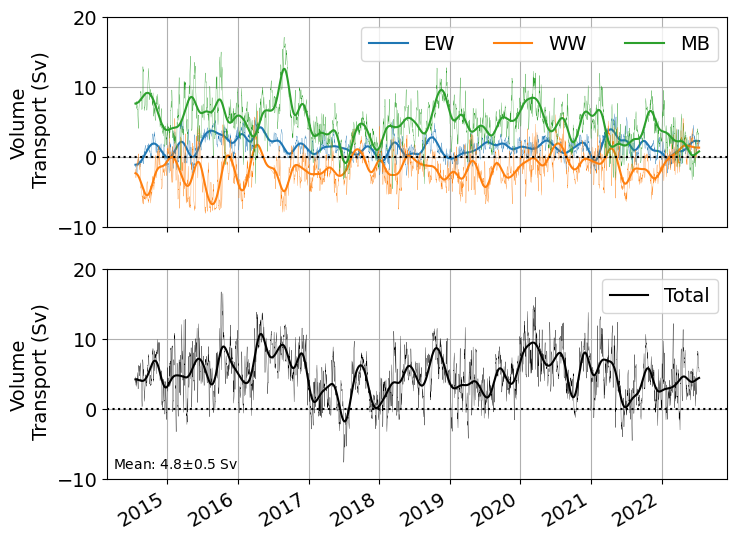

In [54]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Heat Transport

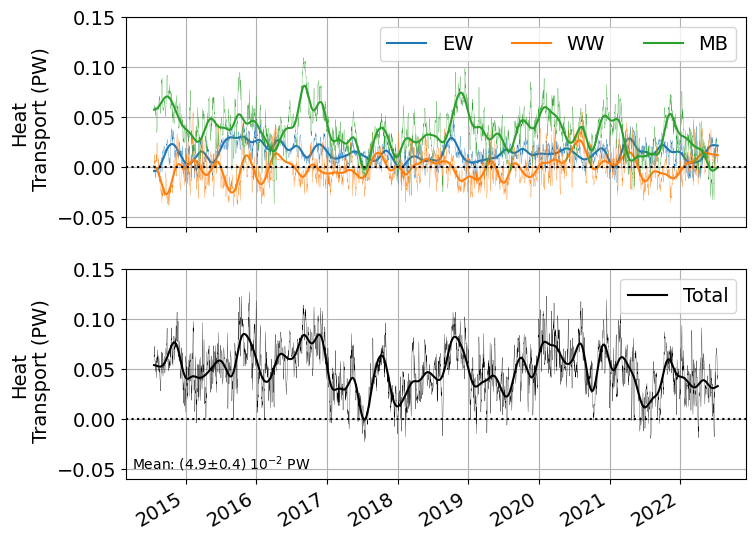

In [55]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

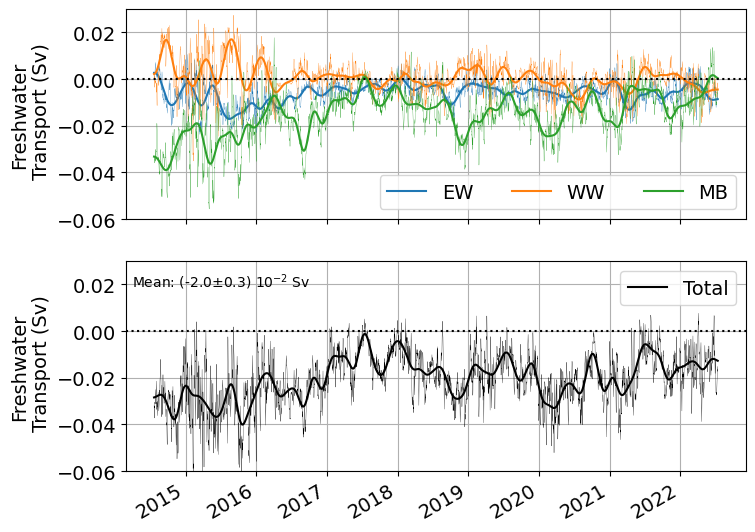

In [56]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Total Transport Timeseries

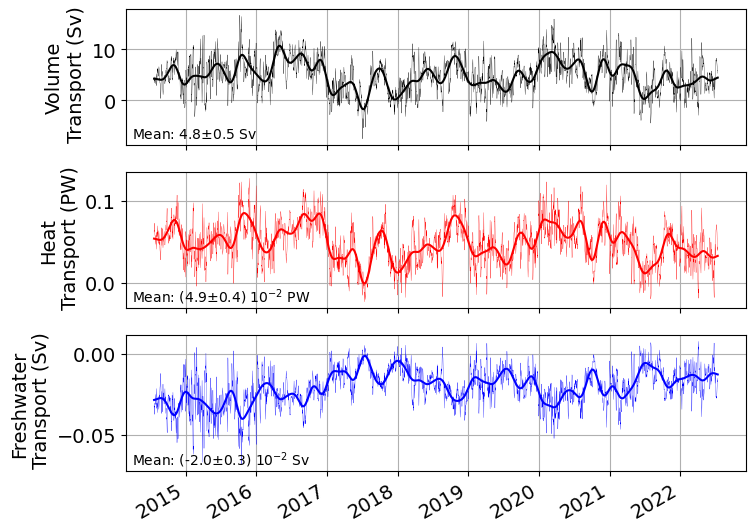

In [57]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values) Q_MB_grid

RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=axs[0],linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=axs[0].transAxes)

RT_Q_Qh_Qf.Qh_tot.plot.line('r',ax=axs[1],linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('r',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

RT_Q_Qh_Qf.Qf_tot.plot.line('b',ax=axs[2],linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('b',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

fig.savefig(fig_out_path/f'Rockall_Trough_total_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Mean Sections

In [58]:
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')

# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

vel_attrs = {'long_name':'Across section velocity',
                 'units':'m/s'}
CT_attrs = {'long_name':'Conservative temperature',
          'description':'conservative temperature TEOS-10',
          'units':'degC'}
SA_attrs = {'long_name':'Absolute salinity',
        'description':'Absolute salinity TEOS-10',
         'units':'g/kg'}

ds_q_RT.v.attrs = vel_attrs
ds_q_RT.CT.attrs = CT_attrs
ds_q_RT.SA.attrs = SA_attrs

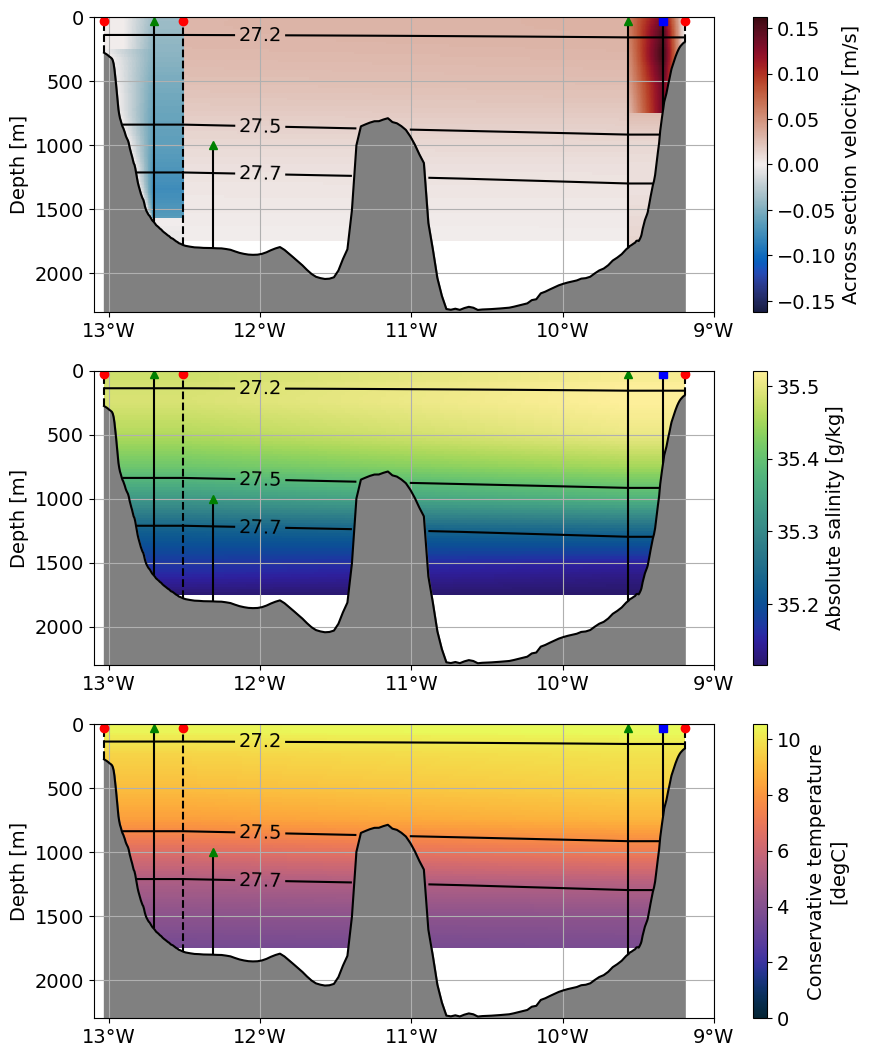

In [59]:
## figure
plt.rcParams.update({'font.size': 14})

xticks = np.arange(-13.,-8,1)
xticklabels = ['13°W','12°W','11°W','10°W','9°W']

sigma_contours = [27.2,27.5, 27.7]
manual_locations = [(-12,100),(-12,900),(-12,1250)]

# Set up figure
fig,axs = plt.subplots(3,1,figsize=[10,13])

ds_q_RT.v.mean('time',keep_attrs=True).plot(ax=axs[0],y='depth',x='lon',yincrease=False,cmap=cm.cm.balance)
ds_q_RT.SA.mean('time',keep_attrs=True).plot(ax=axs[1],y='depth',x='lon',yincrease=False,cmap=cm.cm.haline)
ds_q_RT.CT.mean('time',keep_attrs=True).plot(ax=axs[2],y='depth',x='lon',yincrease=False,cmap=cm.cm.thermal,vmin=0)

for ax in axs:
    ax.fill_between(ds_q_RT.lon, -ds_q_RT.bathy,2300,color='grey')
    (-ds_q_RT.bathy).plot.line('k',ax=ax)
    CS = ds_q_RT.sigma0.mean('time',keep_attrs=True).where(ds_q_RT.depth<=-ds_q_RT.bathy).plot.contour(
        ax=ax,x='lon',levels=sigma_contours,yincrease=False,colors='k')
    ax.clabel(CS,manual=manual_locations)
    
    ax.vlines(ds_RT_loc.lon_RTWB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(ds_RT_loc.lon_RTES,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(ds_RT_loc.lon_RTWS,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
    
    ax.vlines(ds_RT_loc.lon_RTADCP,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
    ax.vlines(ds_RT_loc.lon_RTEB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
    ax.vlines(ds_RT_loc.lon_RTWB1,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')
    ax.vlines(ds_RT_loc.lon_RTWB2,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB2,method='nearest'), 1000,colors='k')
    
    d= 30.
    ax.plot([ds_RT_loc.lon_RTES,ds_RT_loc.lon_RTWS,ds_RT_loc.lon_RTWB],[d,d,d],'or')
    ax.plot([ds_RT_loc.lon_RTADCP],[d],'sb')
    ax.plot([ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTWB1],[d,d],'^g')
    ax.plot([ds_RT_loc.lon_RTWB2],[1000],'^g')
    
    ax.set_xlim([-13.1,-9.])
    ax.set_xlabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=14)
    ax.grid()

    ax.set_ylabel('Depth [m]')
    ax.set_ylim([2300,0])

fig.savefig(fig_out_path/f'Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

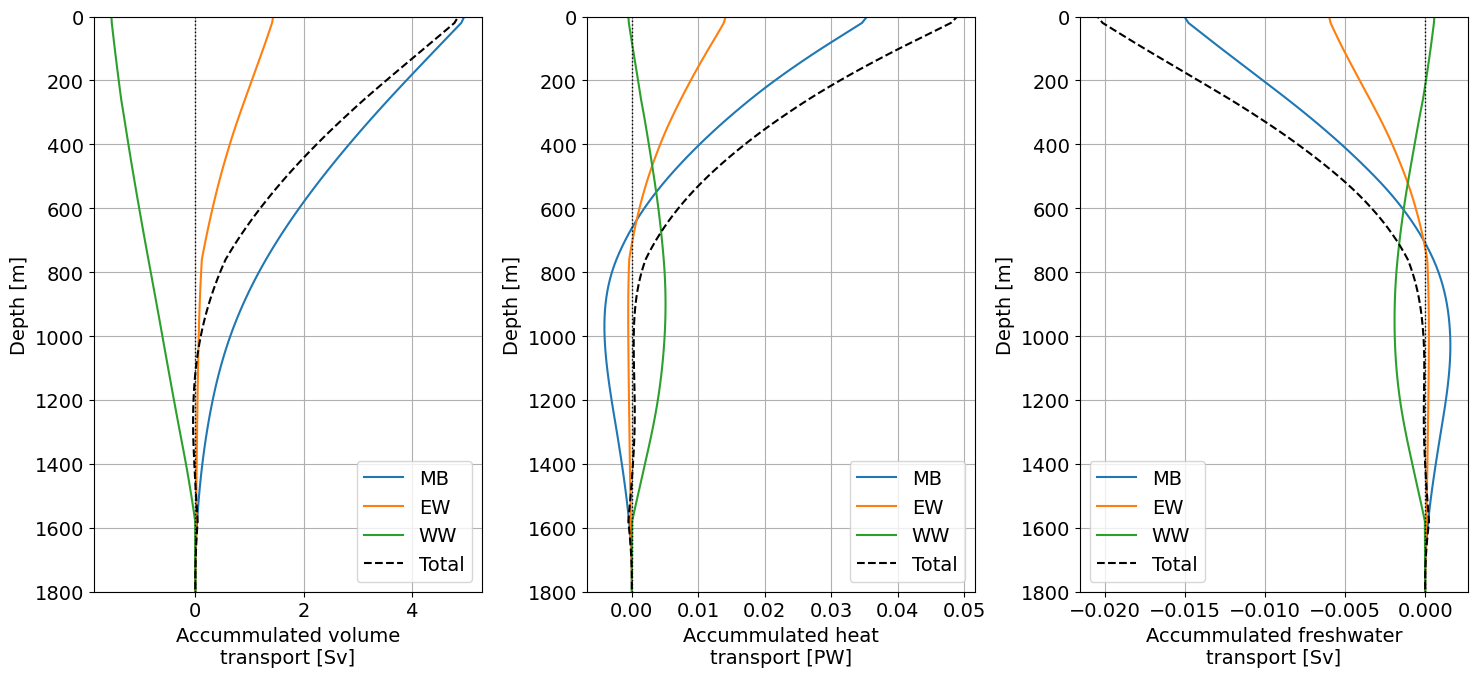

In [60]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_q_RT.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RT.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(qh_MB_grid.sum('lon_MB')/1e15).mean(['TIME']).reindex(depth=qh_MB_grid.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qh_EW.sum('lon_EW')/1e15).mean(['TIME']).reindex(depth=qh_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qh_WW.sum('lon_WW')/1e15).mean(['TIME']).reindex(depth=qh_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qh_MB_grid.sum('lon_MB')+qh_WW.sum('lon_WW')+(qh_EW.sum('lon_EW')))/1e15)
total.mean(['TIME']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(qf_MB_grid.sum('lon_MB')/1e6).mean(['TIME']).reindex(depth=qf_MB_grid.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qf_EW.sum('lon_EW')/1e6).mean(['TIME']).reindex(depth=qf_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qf_WW.sum('lon_WW')/1e6).mean(['TIME']).reindex(depth=qf_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qf_MB_grid.sum('lon_MB')+qf_WW.sum('lon_WW')+(qf_EW.sum('lon_EW')))/1e6)
total.mean(['TIME']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

fig.savefig(fig_out_path/f'Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')